In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import pandas_datareader.data as web
import time
import tensorflow
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
import logging
import math
import os
from sklearn.preprocessing import MinMaxScaler
from keras.utils import np_utils
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation
from keras import optimizers
from sklearn.metrics import mean_squared_error
from keras.models import load_model

Using TensorFlow backend.


In [2]:
np.random.seed(7)

In [3]:
finance_info = pd.read_excel('./data/5년치_재무_LSTM_값.xlsx')

In [4]:
stock_info = pd.read_excel('./data/5년치_주가_LSTM_값.xlsx')

In [5]:
finance_info = finance_info.loc[:,:'주당순손익(원)']

In [6]:
finance_info['year'] = finance_info['거래년월'].str.split('/',1).str[0]
finance_info['month'] = finance_info['거래년월'].str.split('/',1).str[1]

In [7]:
finance_info.head(2)

,회사명,거래소코드,거래년월,자산(백만원),자본(백만원),자본금(백만원),신종자본증권(백만원),자본잉여금(백만원),기타자본(백만원),기타포괄손익누계액(백만원),...,법인세비용차감전순이익(백만원),법인세비용(백만원),계속영업이익(백만원),당기순이익(백만원),기타포괄손익(백만원),총포괄손익(백만원),주당계속영업이익(원),주당순손익(원),year,month
0,(주)BNK금융지주,138930,2013/12,3507652,2737860,966899,0,1638347,0,-189,...,80972,0,80972,80972,-32,80940,419,419,2013,12
1,(주)BNK금융지주,138930,2014/12,4539500,3550847,1171899,0,1945002,0,-1126,...,-17039,0,-17039,-17039,-937,-17976,-143,-143,2014,12


In [8]:
finance_info = finance_info[['회사명', '거래소코드','거래년월', 'year','month', '자산(백만원)', '자본(백만원)', '자본금(백만원)', '신종자본증권(백만원)',
       '자본잉여금(백만원)', '기타자본(백만원)', '기타포괄손익누계액(백만원)', '이익잉여금(백만원)', '부채(백만원)',
       '판매비와관리비(백만원)', '영업손익(백만원)', '기타이익(백만원)', '기타손실(백만원)',
       '법인세비용차감전순이익(백만원)', '법인세비용(백만원)', '계속영업이익(백만원)', '당기순이익(백만원)',
       '기타포괄손익(백만원)', '총포괄손익(백만원)', '주당계속영업이익(원)', '주당순손익(원)']]

In [9]:
finance_info.head(2)

,회사명,거래소코드,거래년월,year,month,자산(백만원),자본(백만원),자본금(백만원),신종자본증권(백만원),자본잉여금(백만원),...,기타이익(백만원),기타손실(백만원),법인세비용차감전순이익(백만원),법인세비용(백만원),계속영업이익(백만원),당기순이익(백만원),기타포괄손익(백만원),총포괄손익(백만원),주당계속영업이익(원),주당순손익(원)
0,(주)BNK금융지주,138930,2013/12,2013,12,3507652,2737860,966899,0,1638347,...,2,0,80972,0,80972,80972,-32,80940,419,419
1,(주)BNK금융지주,138930,2014/12,2014,12,4539500,3550847,1171899,0,1945002,...,58,137,-17039,0,-17039,-17039,-937,-17976,-143,-143


# 거래년월 year / month 로 나눔
### 분기별로 다른 영향을 줄거같음, 원핫코딩으로 month 처리하자

In [10]:
stock_info['year'] = stock_info['거래년월'].str.split('/',1).str[0]
# stock_info['year'] = stock_info['year'].astype(float)
stock_info['month'] = stock_info['거래년월'].str.split('/',1).str[1]
# stock_info['month'] = stock_info['month'].astype(int)

In [11]:
stock_info = stock_info[['회사명',  '거래소코드', '거래년월','year', 'month', '최고가(원)', '최저가(원)', '산술평균(원)', '종가(원)',
       '거래량(주)', '거래대금(원)']]

In [12]:
del stock_info['산술평균(원)']

In [13]:
stock_info.head(2)

,회사명,거래소코드,거래년월,year,month,최고가(원),최저가(원),종가(원),거래량(주),거래대금(원)
0,(주)BNK금융지주,138930,2013/03,2013,03,16900.0,14750.0,15300.0,13476686.0,2.074446e+09
1,(주)BNK금융지주,138930,2013/06,2013,06,16200.0,13150.0,14450.0,13221673.0,1.916348e+09


In [14]:
lstm_data = pd.merge(finance_info, stock_info, on = ['회사명','거래소코드','거래년월','year','month'],how='inner')

In [15]:
lstm_data.head(2)

,회사명,거래소코드,거래년월,year,month,자산(백만원),자본(백만원),자본금(백만원),신종자본증권(백만원),자본잉여금(백만원),...,당기순이익(백만원),기타포괄손익(백만원),총포괄손익(백만원),주당계속영업이익(원),주당순손익(원),최고가(원),최저가(원),종가(원),거래량(주),거래대금(원)
0,(주)BNK금융지주,138930,2013/12,2013,12,3507652,2737860,966899,0,1638347,...,80972,-32,80940,419,419,16500.0,14950.0,16000.0,11624471.0,1.819181e+09
1,(주)BNK금융지주,138930,2014/12,2014,12,4539500,3550847,1171899,0,1945002,...,-17039,-937,-17976,-143,-143,15900.0,14250.0,14500.0,8931317.0,1.340248e+09


In [16]:
lstm_data.columns

Index(['회사명', '거래소코드', '거래년월', 'year', 'month', '자산(백만원)', '자본(백만원)',
       '자본금(백만원)', '신종자본증권(백만원)', '자본잉여금(백만원)', '기타자본(백만원)', '기타포괄손익누계액(백만원)',
       '이익잉여금(백만원)', '부채(백만원)', '판매비와관리비(백만원)', '영업손익(백만원)', '기타이익(백만원)',
       '기타손실(백만원)', '법인세비용차감전순이익(백만원)', '법인세비용(백만원)', '계속영업이익(백만원)',
       '당기순이익(백만원)', '기타포괄손익(백만원)', '총포괄손익(백만원)', '주당계속영업이익(원)', '주당순손익(원)',
       '최고가(원)', '최저가(원)', '종가(원)', '거래량(주)', '거래대금(원)'],
      dtype='object')

# 필요없는 열 삭제 함수

In [17]:
def drop_feature(df):
    
    
#     결측값 처리    
#     df = df.fillna(0)
    
    
    #삭제하고자 하는 열을 입력하면 됨.
    # 1은 열을 제거한다는 뜻
    
   # df = df.drop('year',1) # 월에 비해서 연도 데이터는 필요 없을 듯, 3월의 거시적인 움직임, 12월의 거시적인 움직임은 다를것이기에
                            # month는 살려둠
    # 생각해보니 일단은 담아둬도 될듯 => 5번열부터 x값 입력하면 되기에
    
    df = df.drop('신종자본증권(백만원)',1) # 값이 대부분 0
    
    df = df.drop('주당순손익(원)',1) # 주당계속영업이익과 동일
    

    return df
# 중단영업이익(백만원) 중단영업손익법인세효과(백만원) => 값이 대부분 0이라서 엑셀데이터에서 삭제중
# 다른 열도 엑셀데이터에서 삭제중

In [18]:
lstm_data = drop_feature(lstm_data)

In [19]:
lstm_data.columns

Index(['회사명', '거래소코드', '거래년월', 'year', 'month', '자산(백만원)', '자본(백만원)',
       '자본금(백만원)', '자본잉여금(백만원)', '기타자본(백만원)', '기타포괄손익누계액(백만원)', '이익잉여금(백만원)',
       '부채(백만원)', '판매비와관리비(백만원)', '영업손익(백만원)', '기타이익(백만원)', '기타손실(백만원)',
       '법인세비용차감전순이익(백만원)', '법인세비용(백만원)', '계속영업이익(백만원)', '당기순이익(백만원)',
       '기타포괄손익(백만원)', '총포괄손익(백만원)', '주당계속영업이익(원)', '최고가(원)', '최저가(원)', '종가(원)',
       '거래량(주)', '거래대금(원)'],
      dtype='object')

## 회사명과 거래소코드를 리스트에 담음

In [20]:
list_company = list(set(lstm_data['회사명']))

In [21]:
list_code = list(set(lstm_data['거래소코드']))

## 거래소코드별로 list에 담음

In [22]:
list_code_company = []
for i in range(len(list_code)):
    a2 = lstm_data[lstm_data['거래소코드'] == list_code[i]]
    a2 = a2.sort_values('거래년월')
    list_code_company.append(a2)

In [23]:
len(list_code_company)

188

# 주식 중에서 시계열 데이터가 부족한 자료 찾기
## 20개행이 있어야함: 13년 1분기부터 17년 4분기

In [24]:
list_code_company_1 = []
for i in range(len(list_code_company)):
    if len(list_code_company[i]) == 20:
        list_code_company_1.append(list_code_company[i])


list_code_company = list_code_company_1 
len(list_code_company)

164

## 164개 주식을 가지고 LSTM 모형 만들것

In [25]:
list_code_company_1 = []

for i in range(len(list_code_company)):
    company1 = list_code_company[i]
    company1 = company1.reset_index()
    del company1['index']
    
    stock_price_1year = list_code_company[i]['종가(원)'][4:]
    stock_price_1year = stock_price_1year.reset_index()
    del stock_price_1year['index']
    stock_price_1year.columns = ['1년뒤종가(원)']
    
    a = pd.concat([company1, stock_price_1year], axis = 1)
    a = a.loc[:15,:]
    list_code_company_1.append(a)

In [26]:
list_code_company_1[1]

,회사명,거래소코드,거래년월,year,month,자산(백만원),자본(백만원),자본금(백만원),자본잉여금(백만원),기타자본(백만원),...,당기순이익(백만원),기타포괄손익(백만원),총포괄손익(백만원),주당계속영업이익(원),최고가(원),최저가(원),종가(원),거래량(주),거래대금(원),1년뒤종가(원)
0,금호석유화학(주),11780,2013/03,2013,03,3556331,1242484,167456,276206,-40066,...,42740,-8798,33941,1718,110000.0,99200.0,105500.0,3399162.0,3.572268e+09,87800.0
1,금호석유화학(주),11780,2013/06,2013,06,3440140,1250378,167456,276206,-40066,...,15554,-7660,7894,625,95500.0,77000.0,82700.0,2283953.0,1.945117e+09,88700.0
2,금호석유화학(주),11780,2013/09,2013,09,3395300,1271303,167456,276206,-40066,...,2761,18164,20925,111,103500.0,92100.0,101500.0,4054485.0,4.022779e+09,70100.0
3,금호석유화학(주),11780,2013/12,2013,12,3234382,1164996,167456,276206,-40066,...,-92021,-14287,-106308,-3887,103500.0,90200.0,95200.0,3354700.0,3.235791e+09,80600.0
4,금호석유화학(주),11780,2014/03,2014,03,3201545,1151907,167456,276206,-40066,...,15424,13487,28910,620,91600.0,83900.0,87800.0,2097277.0,1.837234e+09,78500.0
5,금호석유화학(주),11780,2014/06,2014,06,3201518,1186663,167456,276206,-40066,...,34825,-69,34756,1400,89800.0,79500.0,88700.0,2185617.0,1.877677e+09,70800.0
6,금호석유화학(주),11780,2014/09,2014,09,3444540,1189440,167456,276206,-40066,...,17461,-14684,2777,702,81900.0,68100.0,70100.0,3086813.0,2.344042e+09,53200.0
7,금호석유화학(주),11780,2014/12,2014,12,3408864,1233428,167456,276206,-40066,...,15599,28389,43988,439,83700.0,75900.0,80600.0,1369544.0,1.091914e+09,52100.0
8,금호석유화학(주),11780,2015/03,2015,03,3378409,1273398,167456,276206,-40066,...,30603,51366,81968,1096,88500.0,77300.0,78500.0,2326123.0,1.900448e+09,58200.0
9,금호석유화학(주),11780,2015/06,2015,06,3466495,1232290,167456,276206,-40066,...,30465,-71573,-41108,1091,84500.0,69600.0,70800.0,9883034.0,7.477076e+09,59500.0


In [27]:
test = list_code_company_1[0].loc[:,list_code_company_1[0].columns[4:]]
test.head()

,month,자산(백만원),자본(백만원),자본금(백만원),자본잉여금(백만원),기타자본(백만원),기타포괄손익누계액(백만원),이익잉여금(백만원),부채(백만원),판매비와관리비(백만원),...,당기순이익(백만원),기타포괄손익(백만원),총포괄손익(백만원),주당계속영업이익(원),최고가(원),최저가(원),종가(원),거래량(주),거래대금(원),1년뒤종가(원)
0,03,14808505,13026627,468570,5874756,-136097,-3705,6823103,1781878,94069,...,81732,-2001,79731,876,178000.0,157500.0,162000.0,5498416.0,9.117269e+09,122000.0
1,06,14102063,13130491,468570,5874756,-136097,-10035,6933297,971573,75184,...,108071,-4207,103864,1160,152000.0,127000.0,135500.0,5634742.0,7.786675e+09,113000.0
2,09,14568016,13178282,468570,5874756,-136097,-8858,6979912,1389733,71859,...,46549,1243,47792,499,152500.0,136500.0,146000.0,8023427.0,1.170746e+10,81100.0
3,12,14486694,13171828,468570,5874755,-136097,-11046,6975646,1314866,87222,...,680,-7134,-6454,-2,145500.0,136000.0,141500.0,5232655.0,7.339417e+09,85100.0
4,03,14696306,13126743,468570,5874756,-136097,-14205,6933719,1569563,82723,...,262808,-9615,253193,2819,134500.0,117000.0,122000.0,6321598.0,7.891333e+09,95400.0


# LSTM 모델 : 1개 종목

모델 개요
- 단순하게 2013년 1분기 데이터를 변수로 보고, 2014년 1분기 데이터를 예측하는 모델
- 13,14,15년은 Train
- 16은 Test  
=> 즉 16년 1분기를 보고 17년 1분기 예측

In [28]:
'''
## import pandas as pd
import pandas_datareader.data as web
import tensorflow
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
import logging
import math
import os
from sklearn.preprocessing import MinMaxScaler
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation
from keras import optimizers
from sklearn.metrics import mean_squared_error
from keras.models import load_model
from keras.utils import np_utils

### 데이터 전처리 / Data Preprocessing

np.random.seed(123)
# finance_indicator = test.loc[:,"자산(백만원)":].astype(np.float) # 재부 관련 지표
# month_indicator = test.loc[:,"month"].astype(np.float) # 월 관련 지표

indicator = test.values.astype(np.float)
scaler = MinMaxScaler(feature_range=(0, 1)) # 0~1 값으로 스케일링
scaled_test = scaler.fit_transform(indicator) # 가격 관련 지표에 스케일링
#month_indicator = np_utils.to_categorical(month_indicator)

#scaler_etc = MinMaxScaler(feature_range=(-1, 1)) # 0~1 값으로 스케일링
#scaled_etc_indicator = scaler_etc.fit_transform(etc_indicator) # 추세 또는 거래량 활용 지표에 스케일링



x = scaled_test
y = x[:, [25]] # 타켓은 1년뒤 종가이다 / target is 'Close' price


# dataX와 dataY 생성 / Creating dataset 'dataX' and 'dataY'
seq_length = 4 # 4분기 데이터를 이용해 1년뒤 예상

dataX = [] # 입력으로 사용될 Sequence Data / Input - Sequence Data
dataY = [] # 출력(타켓)으로 사용 / Output(target)
for i in range(0, int(len(y) - seq_length)):
    _x = x[i : i + seq_length]
    _y = y[i + seq_length - 1] # 다음 나타날 주가(정답) / after 5 days later (in _x), 'Close' price is the correct answer.
    dataX.append(_x) # dataX 리스트에 추가 / add to dataX's list
    dataY.append(_y) # dataY 리스트에 추가 / add to dataY's list
    print(_x[0:4])
    print('--------------')
    print(_y[0])
    print('--------------')
    
    

# 학습용/테스트용 데이터 생성
train_data_size = 0.67 # 입력하는 데이터 중에서 60퍼센트는 train 데이터로 사용
train_size = int(len(dataY) * train_data_size)
test_size = len(dataY) - train_size  # test 데이터: 4개

# 데이터를 잘라 학습용 데이터 생성
trainX = np.array(dataX[0:train_size])
trainY = np.array(dataY[0:train_size])

# 데이터를 잘라 테스트용 데이터 생성
testX = np.array(dataX[train_size:len(dataX)])
testY = np.array(dataY[train_size:len(dataY)])

print("="*50)
print(_x.shape)
print(_y.shape)
print(trainX.shape)
print(trainY.shape)
print("="*50)



## LSTM 모델

input_columns = 26

model = Sequential()
model.add(LSTM(64, input_dim=input_columns, input_length=seq_length, return_sequences=True, stateful=False))
model.add(LSTM(64, return_sequences=False, stateful=False))
model.add(Dense(1))
model.add(Activation('linear'))
# , dropout=0.2


# 모델 학습 설정 및 진행
keras.optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()
print("="*50)
hist = model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=1, validation_data=(testX, testY))


# 학습 과정 살펴보기
print(hist.history['loss'])
print(hist.history['val_loss'])
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()
loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')
plt.show()



# 예측
y_pred = model.predict(testX, batch_size=1, verbose=1) # , steps=5
plt.plot(testY, color = 'blue', label = 'Actual Stock Price')
plt.plot(y_pred, color = 'red', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


# 모델 저장
model.save('lstm_stock_prediction_01.h5')

# cf. 모델 로드하는거!
#model = load_model('lstm_stock_prediction_01.h5')
'''

'\n## import pandas as pd\nimport pandas_datareader.data as web\nimport tensorflow\nimport matplotlib.pyplot as plt\nimport datetime as dt\nimport numpy as np\nimport logging\nimport math\nimport os\nfrom sklearn.preprocessing import MinMaxScaler\nimport keras\nfrom keras.models import Sequential\nfrom keras.layers import Dense, LSTM, Activation\nfrom keras import optimizers\nfrom sklearn.metrics import mean_squared_error\nfrom keras.models import load_model\nfrom keras.utils import np_utils\n\n### 데이터 전처리 / Data Preprocessing\n\nnp.random.seed(123)\n# finance_indicator = test.loc[:,"자산(백만원)":].astype(np.float) # 재부 관련 지표\n# month_indicator = test.loc[:,"month"].astype(np.float) # 월 관련 지표\n\nindicator = test.values.astype(np.float)\nscaler = MinMaxScaler(feature_range=(0, 1)) # 0~1 값으로 스케일링\nscaled_test = scaler.fit_transform(indicator) # 가격 관련 지표에 스케일링\n#month_indicator = np_utils.to_categorical(month_indicator)\n\n#scaler_etc = MinMaxScaler(feature_range=(-1, 1)) # 0~1 값으로 스케일링\n#sca

# 모델2 : 기업 1개로만 한거

In [29]:
# np.random.seed(125)


# test = list_code_company_1[0].loc[:,list_code_company_1[0].columns[4:]]
# test1 = test.loc[:,"month":"거래대금(원)"]
# ### 데이터 전처리 / Data Preprocessing
# # finance_indicator = test.loc[:,"자산(백만원)":].astype(np.float) # 재부 관련 지표
# # month_indicator = test.loc[:,"month"].astype(np.float) # 월 관련 지표

# # indicator = test.values.astype(np.float)
# indicator = test.values.astype(np.float)
# indicator1 = test1.values.astype(np.float)



# scaler = MinMaxScaler(feature_range=(0, 1)) # 0~1 값으로 스케일링

# scaled_test = scaler.fit_transform(indicator) # 가격 관련 지표에 스케일링
# scaled_test1 = scaler.fit_transform(indicator1)


# #month_indicator = np_utils.to_categorical(month_indicator)

# #scaler_etc = MinMaxScaler(feature_range=(-1, 1)) # 0~1 값으로 스케일링
# #scaled_etc_indicator = scaler_etc.fit_transform(etc_indicator) # 추세 또는 거래량 활용 지표에 스케일링


# x = scaled_test1
# y = scaled_test[:, [25]] # 타켓은 1년뒤 종가이다 / target is 'Close' price
# #print(len(x)) 16개
# #print(len(y))16개


# # dataX와 dataY 생성 / Creating dataset 'dataX' and 'dataY'
# seq_length = 4 # 4분기 데이터를 이용해 1년뒤 예상

# dataX = [] # 입력으로 사용될 Sequence Data / Input - Sequence Data
# dataY = [] # 출력(타켓)으로 사용 / Output(target)
# for i in range(0, int(len(y) - seq_length)):
#     _x = x[i : i + seq_length]
#     _y = y[i + seq_length - 1] # 다음해 나타날 주가(정답) / after 5 days later (in _x), 'Close' price is the correct answer.
#     dataX.append(_x) # dataX 리스트에 추가 / add to dataX's list
#     dataY.append(_y) # dataY 리스트에 추가 / add to dataY's list
#     print(_x)


# # 학습용/테스트용 데이터 생성
# train_data_size = 0.67 # 입력하는 데이터 중에서 60퍼센트는 train 데이터로 사용
# train_size = int(len(dataY) * train_data_size)
# test_size = len(dataY) - train_size  # test 데이터: 4개

# # 데이터를 잘라 학습용 데이터 생성
# trainX = np.array(dataX[0:train_size])
# trainY = np.array(dataY[0:train_size])

# # 데이터를 잘라 테스트용 데이터 생성
# testX = np.array(dataX[train_size:len(dataX)])
# testY = np.array(dataY[train_size:len(dataY)])

# print("="*50)
# print(_x.shape)
# print(_y.shape)
# print(trainX.shape)
# print(trainY.shape)
# print("="*50)

# # 모델 불러오기
# model = load_model('lstm_stock_prediction_01.h5')

# ## LSTM 모델

# input_columns = 25

# # 최초로는 모델 만들어야 하나 이후에는 학습시킬것
# model = Sequential()
# model.add(LSTM(64, input_dim=input_columns, input_length=seq_length, return_sequences=True, stateful=False))
# model.add(LSTM(64, return_sequences=False, stateful=False))
# model.add(Dense(1))
# model.add(Activation('linear'))
# # , dropout=0.2



# # 모델 학습 설정 및 진행
# keras.optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
# model.compile(loss='mean_squared_error', optimizer='adam')
# model.summary()
# print("="*50)
# hist = model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=1, validation_data=(testX, testY))


# # 학습 과정 살펴보기
# #     print(hist.history['loss'])
# #     print(hist.history['val_loss'])
# fig, loss_ax = plt.subplots()
# acc_ax = loss_ax.twinx()
# loss_ax.plot(hist.history['loss'], 'y', label='train loss')
# loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
# loss_ax.set_xlabel('epoch')
# loss_ax.set_ylabel('loss')
# loss_ax.legend(loc='upper left')
# acc_ax.legend(loc='lower left')
# plt.show()


# # 예측
# y_pred = model.predict(testX, batch_size=1, verbose=1) # , steps=5
# plt.plot(testY, color = 'blue', label = 'Actual Stock Price')
# plt.plot(y_pred, color = 'red', label = 'Predicted Stock Price')
# plt.title('Stock Price Prediction')
# plt.xlabel('Time')
# plt.ylabel('Stock Price')
# #plt.legend()
# plt.show()

# print(list_code_company_1[0]['회사명'].values[0])
# print('=====================================================')
# # 모델 저장
# model.save('lstm_stock_prediction_02_종가제외.h5')


# # cf. 모델 로드하는거!
# #model = load_model('lstm_stock_prediction_01.h5')

# 모델 2: for 문 - 모델 만들지 않고 로드해서 쓸것
  
### 기업 전부에 대해서 업데이트 시키는 모델

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 4, 64)             23040     
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 56,129
Trainable params: 56,129
Non-trainable params: 0
_________________________________________________________________
Train on 8 samples, validate on 4 samples
Epoch 1/50
8/8 [==============================] - 22s 3s/step - loss: 0.0635 - val_loss: 0.1669
Epoch 2/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0248 - val_loss: 0.1004
Epoch 3/50
8/8 [===================

No handles with labels found to put in legend.


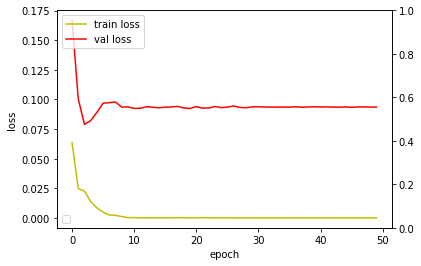

4/4 [==============================] - 9s 2s/step


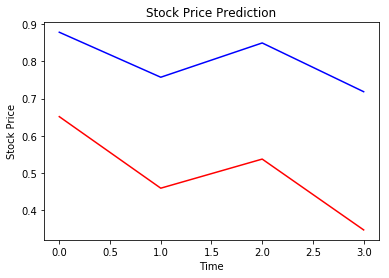

17 번째
(주)삼양사
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 4, 64)             23040     
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 56,129
Trainable params: 56,129
Non-trainable params: 0
_________________________________________________________________
Train on 8 samples, validate on 4 samples
Epoch 1/50
8/8 [==============================] - 24s 3s/step - loss: 0.0821 - val_loss: 0.0210
Epoch 2/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0105 - val_loss: 0.0139
Epoch 3/50
8/8 [======

No handles with labels found to put in legend.


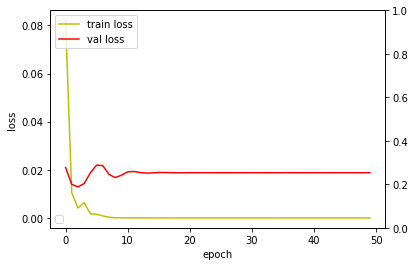

4/4 [==============================] - 9s 2s/step


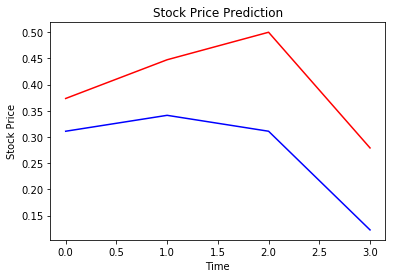

18 번째
(주)삼양홀딩스
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 4, 64)             23040     
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 56,129
Trainable params: 56,129
Non-trainable params: 0
_________________________________________________________________
Train on 8 samples, validate on 4 samples
Epoch 1/50
8/8 [==============================] - 26s 3s/step - loss: 0.0690 - val_loss: 0.0302
Epoch 2/50
8/8 [==============================] - 0s 15ms/step - loss: 0.0404 - val_loss: 0.0273
Epoch 3/50
8/8 [====

No handles with labels found to put in legend.


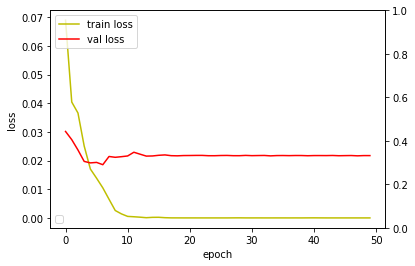

4/4 [==============================] - 9s 2s/step


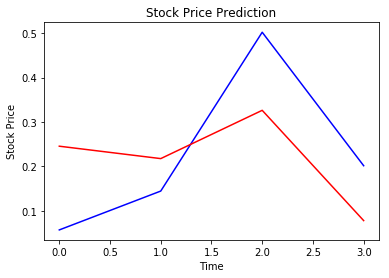

19 번째
(주)신세계
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 4, 64)             23040     
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 56,129
Trainable params: 56,129
Non-trainable params: 0
_________________________________________________________________
Train on 8 samples, validate on 4 samples
Epoch 1/50
8/8 [==============================] - 25s 3s/step - loss: 0.0727 - val_loss: 0.1286
Epoch 2/50
8/8 [==============================] - 0s 15ms/step - loss: 0.0558 - val_loss: 0.1400
Epoch 3/50
8/8 [======

No handles with labels found to put in legend.


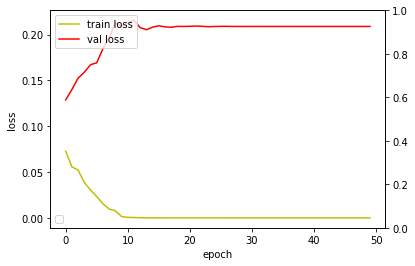

4/4 [==============================] - 9s 2s/step


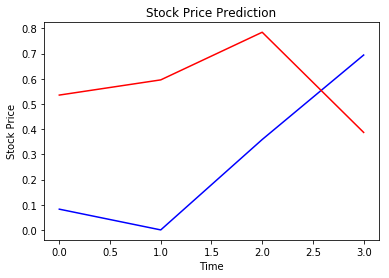

20 번째
하이트진로(주)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 4, 64)             23040     
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 56,129
Trainable params: 56,129
Non-trainable params: 0
_________________________________________________________________
Train on 8 samples, validate on 4 samples
Epoch 1/50
8/8 [==============================] - 24s 3s/step - loss: 0.0383 - val_loss: 0.3093
Epoch 2/50
8/8 [==============================] - 0s 15ms/step - loss: 0.0105 - val_loss: 0.3049
Epoch 3/50
8/8 [====

No handles with labels found to put in legend.


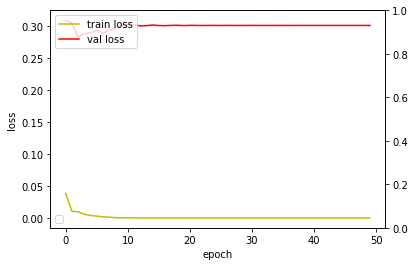

4/4 [==============================] - 9s 2s/step


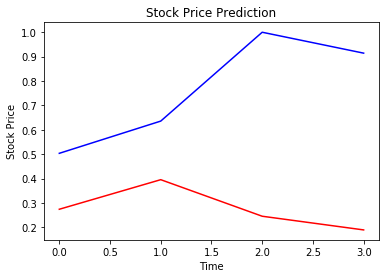

21 번째
(주)지에스
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 4, 64)             23040     
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 56,129
Trainable params: 56,129
Non-trainable params: 0
_________________________________________________________________
Train on 8 samples, validate on 4 samples
Epoch 1/50
8/8 [==============================] - 24s 3s/step - loss: 0.0158 - val_loss: 0.1620
Epoch 2/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0032 - val_loss: 0.2104
Epoch 3/50
8/8 [======

No handles with labels found to put in legend.


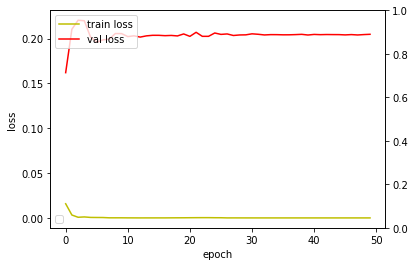

4/4 [==============================] - 9s 2s/step


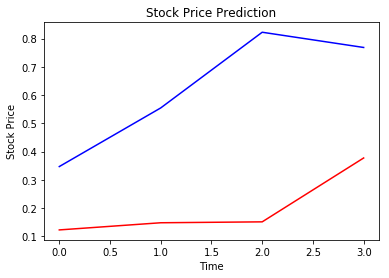

22 번째
(주)KB금융지주
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 4, 64)             23040     
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 56,129
Trainable params: 56,129
Non-trainable params: 0
_________________________________________________________________
Train on 8 samples, validate on 4 samples
Epoch 1/50
8/8 [==============================] - 25s 3s/step - loss: 0.1453 - val_loss: 0.3236
Epoch 2/50
8/8 [==============================] - 0s 16ms/step - loss: 0.0771 - val_loss: 0.2344
Epoch 3/50
8/8 [===

No handles with labels found to put in legend.


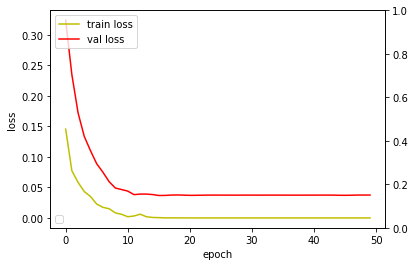

4/4 [==============================] - 10s 2s/step


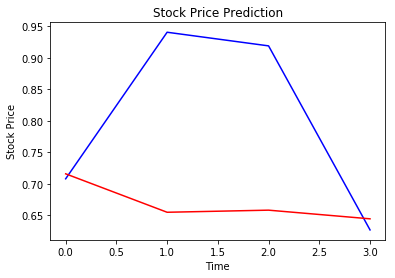

23 번째
네이버(주)


KeyboardInterrupt: 

In [32]:
np.random.seed(270)

for i in range(len(list_code_company_1)):

    test = list_code_company_1[i+24].loc[:,list_code_company_1[i+24].columns[4:]]
    test1 = test.loc[:,"month":"거래대금(원)"]
    ### 데이터 전처리 / Data Preprocessing
    # finance_indicator = test.loc[:,"자산(백만원)":].astype(np.float) # 재부 관련 지표
    # month_indicator = test.loc[:,"month"].astype(np.float) # 월 관련 지표

    # indicator = test.values.astype(np.float)
    indicator = test.values.astype(np.float) # 종가 뽑아내려고
    indicator1 = test1.values.astype(np.float) # 종가 제외한 피쳐



    scaler = MinMaxScaler(feature_range=(0, 1)) # 0~1 값으로 스케일링

    scaled_test = scaler.fit_transform(indicator) # 가격 관련 지표에 스케일링
    scaled_test1 = scaler.fit_transform(indicator1)


    #month_indicator = np_utils.to_categorical(month_indicator)

    #scaler_etc = MinMaxScaler(feature_range=(-1, 1)) # 0~1 값으로 스케일링
    #scaled_etc_indicator = scaler_etc.fit_transform(etc_indicator) # 추세 또는 거래량 활용 지표에 스케일링


    x = scaled_test1
    y = scaled_test[:, [25]] # 타켓은 1년뒤 종가이다 / target is 'Close' price
    #print(len(x)) 16개
    #print(len(y))16개


    # dataX와 dataY 생성 / Creating dataset 'dataX' and 'dataY'
    seq_length = 4 # 4분기 데이터를 이용해 1년뒤 예상

    dataX = [] # 입력으로 사용될 Sequence Data / Input - Sequence Data
    dataY = [] # 출력(타켓)으로 사용 / Output(target)
    for j in range(0, int(len(y) - seq_length)):
        _x = x[j : j + seq_length]
        _y = y[j + seq_length - 1] # 다음해 나타날 주가(정답) / after 5 days later (in _x), 'Close' price is the correct answer.
        dataX.append(_x) # dataX 리스트에 추가 / add to dataX's list
        dataY.append(_y) # dataY 리스트에 추가 / add to dataY's list
       


    # 학습용/테스트용 데이터 생성
    train_data_size = 0.67 # 입력하는 데이터 중에서 60퍼센트는 train 데이터로 사용
    train_size = int(len(dataY) * train_data_size)
    test_size = len(dataY) - train_size  # test 데이터: 4개

    # 데이터를 잘라 학습용 데이터 생성
    trainX = np.array(dataX[0:train_size])
    trainY = np.array(dataY[0:train_size])

    # 데이터를 잘라 테스트용 데이터 생성
    testX = np.array(dataX[train_size:len(dataX)])
    testY = np.array(dataY[train_size:len(dataY)])


    ## LSTM 모델

    input_columns = 25

    
    # 모델 로드
    model = load_model('./save/lstm_stock_prediction_02_종가제외.h5')


    # 모델 학습 설정 및 진행
    keras.optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.summary()
    print("="*50)
    hist = model.fit(trainX, trainY, epochs=50, batch_size=1, verbose=1, validation_data=(testX, testY))


    # 학습 과정 살펴보기
    #     print(hist.history['loss'])
    #     print(hist.history['val_loss'])
    fig, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()
    loss_ax.plot(hist.history['loss'], 'y', label='train loss')
    loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    loss_ax.legend(loc='upper left')
    acc_ax.legend(loc='lower left')
    plt.show()


    # 예측
    y_pred = model.predict(testX, batch_size=1, verbose=1) # , steps=5
    plt.plot(testY, color = 'blue', label = 'Actual Stock Price')
    plt.plot(y_pred, color = 'red', label = 'Predicted Stock Price')
    plt.title('Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    #plt.legend()
    plt.show()
    
    print(i+24,'번째')
    print(list_code_company_1[i+24]['회사명'].values[0])
    print('=====================================================')
    # 모델 저장
    model.save('./save/lstm_stock_prediction_02_종가제외.h5')
    time.sleep(0.5)

model.save('./save/lstm_stock_prediction_02_종가제외_완료.h5')

